# Description

* Creating OTUs with usearch

# Init

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/150522_run1_rerun/OTU_binning/'
databaseDir = '/home/bryan/RhizCG/data/databases/'
nprocs = 24

In [2]:
import os
import re
import pandas as pd
from qiime.assign_taxonomy import UclustConsensusTaxonAssigner
from IPython.display import Image

In [3]:
%pylab inline
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(stringr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [5]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Binning

In [6]:
%%bash -s "$workDir"

cd $1

ln -f -s ../QC/finalQC.fasta .

printf "Number of sequences in final QC fasta: "
grep -c ">" finalQC.fasta

head -n 4 finalQC.fasta
tail -n 4 finalQC.fasta

Number of sequences in final QC fasta: 5134019
>sample6-3.07_Npos_0
TACAGAGGGTGCAAACGTTGCTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGCTCCGTAAGTCGGGTGTGAAATCCCTCGGCTCAACTGAGGAAGTGCACTCGATACTGCAGAGCTAGAGTACCGGAGAGGGTGGTGGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAACACCGGCGGCGAAGGCGGCCACCTGGACGGATACTGACGCTCAGACGCGAAAGCGTGGGTAGCAAACAGG
>sample1-3.07_Nneg_2492020
TACAGAGGGTGCAAACGTTGCTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGCTCCGTAAGTCGGGTGTGAAATCCCTCGGCTCAACTGAGGAAGTGCACTCGATACTGCAGAGCTAGAGTACCGGAGAGGGTGGTGGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAACACCGGCGGCGAAGGCGGCCACCTGGACGGATACTGACGCTCAGACGCGAAAGCGTGGGTAGCAAACAGG
>sample5-4.09_Nneg_5228493
TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGCTCGGAGGCGGTTCGGTAAGTCGGCTGTGAAATCTCCACGCTCAACGTGGGGGGGTCAGTCGAAACTGCCGTGACTCGAGTCCGGTAGAGGAGTGTGGAATTCCCGGTGTAGCGGTGAAATGCGCAGAGATCGGGAGGAACACCCGTAGCGAAGGCGGCACTCTGGGCCGGTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCAAACAGG
>sample2-2.08_Nneg_5228496
GACGGGGGGGGCAAGTGTTCTGCGGAATGACTGGGCGTAAAGGGCACGTAGGCGGTGAATCGGGTTGAAAGTGAAAGTCGCCAAAAAC

# Usearch pipeline

In [7]:
!cd $workDir; \
    usearch -derep_fulllength finalQC.fasta -output finalQC_uniques.fasta -sizeout -threads $nprocs

usearch v7.0.1090_i86linux32, 4.0Gb RAM (132Gb total), 40 cores
(C) Copyright 2013 Robert C. Edgar, all rights reserved.
http://drive5.com/usearch

Licensed to: chuck.peperanney@gmail.com

00:06 1.6Gb  100.0% Reading finalQC.fasta
00:11 2.0Gb 3276531 (3.3M) uniques, avg cluster 1.6, median 1, max 226215
00:35 2.0Gb  100.0% Writing finalQC_uniques.fasta


In [8]:
!cd $workDir; \
    usearch -sortbysize finalQC_uniques.fasta \
    -output finalQC_uniques_sorted.fasta -minsize 2  #-minsize 2

usearch v7.0.1090_i86linux32, 4.0Gb RAM (132Gb total), 40 cores
(C) Copyright 2013 Robert C. Edgar, all rights reserved.
http://drive5.com/usearch

Licensed to: chuck.peperanney@gmail.com

00:00 2.1Mb Reading finalQC_uniques.fasta, 956Mb
00:02 958Mb 3276531 (3.3M) seqs, min 233, avg 253, max 354nt
00:04 998Mb Getting sizes
00:08 1.0Gb Sorting 203658 sequences
00:09 1.0Gb  100.0% Writing finalQC_uniques_sorted.fasta


In [9]:
!cd $workDir; \
    tail finalQC_uniques_sorted.fasta

>sample6-4.27_Nneg_3497443;size=2;
AACGTAGGGTGCAAGCGTTGCCCGGATTTATTGGGCGTAAAGGGCGCGTAGGCGGCTACGCACGTCCGTTGTGAAATCGC
CCGGCTCAACTGGGCGGGGTCGGCGGATACGGCGTAGCTGGAGCAAGCTAGGGGGCAATGGAATTCCCGGTGTAGTGGTG
GAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGTTGCCTGGGGCTTTGCTGACGCTGATGCGCGAAAGCGTG
GGGAGCGATCCGG
>sample1-2.23_Nneg_2415313;size=2;
TACGGGGGGAGCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGCGCGTAGGCGGCCACCGCAAGTCGACTGTGAAACCT
CCGGGCTTAACCCGGAAAGGGCAGCCGATACTGCGGGGCTAGAGTGCAGAAGGGGCAACTGGAATTCTCGGTGTAGCGGT
GAAATGCGTAGATATCGAGAGGAACACCTGCGGCGAAGGCGGGTTGCTGGGCTGACACTGACGCTGAGGCGCGAAAGCTA
GGGGAGCGAACGGG


In [10]:
!cd $workDir; \
    usearch -cluster_otus finalQC_uniques_sorted.fasta -otus otus.fasta

usearch v7.0.1090_i86linux32, 4.0Gb RAM (132Gb total), 40 cores
(C) Copyright 2013 Robert C. Edgar, all rights reserved.
http://drive5.com/usearch

Licensed to: chuck.peperanney@gmail.com

01:43 210Mb  100.0% 7731 OTUs
                             
Input seqs  203658 (203.7k)
      OTUs  7731
   Members  159848 (159.8k)
  Chimeras  36079 (36.1k)
   Max mem  210Mb
      Time  01:43
Throughput  1977.3 seqs/sec.



In [11]:
!cd $workDir; \
    /opt/bioinfo/edgar_python_scripts/fasta_number.py otus.fasta OTU. > otusn.fasta

# Removing sequences classified as chloroplast, eukaryotes, or archaea

In [12]:
%%bash -s "$workDir" "$databaseDir" "$nprocs"

cd $1

parallel_assign_taxonomy_uclust.py \
    -r $2'97_Silva_111_rep_set_no_ambig.fasta' \
    -t $2'Silva_111_taxa_map_full.txt' \
    -O 8 \
    -i otusn.fasta \
    -o otusn_tax

In [13]:
%%bash -s "$workDir" "$databaseDir"

cd $1

egrep "Chloroplast|Eukaryota|Archaea|Unassigned|mitochondria" \
    otusn_tax/otusn_tax_assignments.txt |\
    awk '{print $1}' > to_remove_tax.accnos

In [14]:
!cd $workDir; wc -l to_remove_tax.accnos

636 to_remove_tax.accnos


In [15]:
!cd $workDir; head to_remove_tax.accnos

OTU.699
OTU.902
OTU.765
OTU.377
OTU.77
OTU.73
OTU.883
OTU.298
OTU.1
OTU.2


In [16]:
!cd $workDir; \
    mothur "#remove.seqs(fasta=otusn.fasta, accnos=to_remove_tax.accnos)" | head -n 50







mothur v.1.35.1
Last updated: 03/31/2015

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > remove.seqs(fasta=otusn.fasta, accnos=to_remove_tax.accnos)
Removed 636 sequences from your fasta file.

Output File Names: 
otusn.pick.fasta


mothur > quit()


In [17]:
!cd $workDir; grep -c ">" otusn.fasta
!cd $workDir; grep -c ">" otusn.pick.fasta

7731
7095


# Mapping reads

In [18]:
%%bash -s "$workDir"

cd $1

perl -pe 's/^>(.+)(_[^_]+)\n$/>$1$2;barcodelabel=$1\n/' finalQC.fasta > finalQC_usearchfmt.fasta

In [19]:
!cd $workDir; head finalQC_usearchfmt.fasta

>sample6-3.07_Npos_0;barcodelabel=sample6-3.07_Npos
TACAGAGGGTGCAAACGTTGCTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGCTCCGTAAGTCGGGTGTGAAATCCCTCGGCTCAACTGAGGAAGTGCACTCGATACTGCAGAGCTAGAGTACCGGAGAGGGTGGTGGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAACACCGGCGGCGAAGGCGGCCACCTGGACGGATACTGACGCTCAGACGCGAAAGCGTGGGTAGCAAACAGG
>sample1-3.07_Nneg_2492020;barcodelabel=sample1-3.07_Nneg
TACAGAGGGTGCAAACGTTGCTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGCTCCGTAAGTCGGGTGTGAAATCCCTCGGCTCAACTGAGGAAGTGCACTCGATACTGCAGAGCTAGAGTACCGGAGAGGGTGGTGGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAACACCGGCGGCGAAGGCGGCCACCTGGACGGATACTGACGCTCAGACGCGAAAGCGTGGGTAGCAAACAGG
>sample1-3.07_Nneg_2492211;barcodelabel=sample1-3.07_Nneg
TACAGAGGGTGCAAACGTTGCTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGCTCCGTAAGTCGGGTGTGAAATCCCTCGGCTCAACTGAGGAAGTGCACTCGATACTGCAGAGCTAGAGTACCGGAGAGGGTGGTGGAATTCCTGGTGTAGAGGTGAAATTCGTAGATATCAGGAGGAACACCGGCGGCGAAGGCGGCCACCTGGACGGATACTGACGCTCAGACGCGAAAGCGTGGGTAGCAAACAGG
>sample3-3.07_Npos_2711613;barcodelabel=sample3-3.07_Npos
TACAGAGGGTGC

In [20]:
!cd $workDir; grep -c ">" finalQC_usearchfmt.fasta

5134019


In [21]:
!cd $workDir; \
usearch -usearch_global finalQC_usearchfmt.fasta \
    -db otusn.pick.fasta \
    -strand plus -id 0.97 \
    -uc readmap.uc \
    -threads $nprocs

usearch v7.0.1090_i86linux32, 4.0Gb RAM (132Gb total), 40 cores
(C) Copyright 2013 Robert C. Edgar, all rights reserved.
http://drive5.com/usearch

Licensed to: chuck.peperanney@gmail.com

00:00  19Mb Reading otusn.pick.fasta, 1.9Mb
00:00  21Mb 7095 seqs, min 243, avg 253, max 278nt
00:00  21Mb  100.0% Masking
00:00  21Mb  100.0% Word stats
00:00  29Mb  100.0% Building slots
00:00  29Mb  100.0% Build index
01:01 278Mb  100.0% Searching, 44.1% matched


In [22]:
!cd $workDir; \
    python /opt/bioinfo/edgar_python_scripts/uc2otutab.py readmap.uc > otu_table.txt

readmap.uc 100.0%   


In [23]:
%%bash -s "$workDir"

cd $1

if [ -f otu_table.biom ]; then
    rm otu_table.biom
fi #This is to mitigate a biom bug

biom convert -i otu_table.txt -o otu_table.biom --table-type "otu table"

In [24]:
%%bash -s "$workDir"

cd $1

if [ -f otu_table_summary.txt ]; then
    rm otu_table_summary.txt
fi #This is to mitigate a biom bug

biom summarize-table -i otu_table.biom -o otu_table_summary.txt

In [25]:
!cd $workDir; cat otu_table_summary.txt

Num samples: 139
Num observations: 7095
Total count: 2246311
Table density (fraction of non-zero values): 0.315
Table md5 (unzipped): 59079cfbed5edba770d564cb700d8654

Counts/sample summary:
 Min: 1.0
 Max: 53857.0
 Median: 14479.000
 Mean: 16160.511
 Std. dev.: 9719.549
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
 H20_Control: 1.0
 Negative_Control: 13.0
 Positive_Control: 26.0
 sample3-1.09_Npos: 4206.0
 sample2-1.08_Npos: 4627.0
 sample5-1.29_Npos: 5069.0
 sample3-1.09_Nneg: 5216.0
 sample3-3.06_Npos: 5711.0
 sample2-1.08_Nneg: 5862.0
 sample5-1.22_Npos: 5872.0
 sample3-2.03_Npos: 5978.0
 sample1-1.27_Npos: 6315.0
 sample2-3.05_Npos: 6622.0
 sample4-1.03_Npos: 6647.0
 sample5-3.11_Npos: 6733.0
 sample5-1.25_Npos: 6801.0
 sample4-1.03_Nneg: 7137.0
 sample5-3.27_Npos: 7155.0
 sample5-1.16_Npos: 7171.0
 sample1-3.08_Npos: 7296.0
 sample1-1.27_Nneg: 7312.0
 sample5-3.16_Npos: 7331.0
 sample5-2.18_Npos: 7757.0
 sample5

# Assessing the taxonomic composition in the water controls

In [26]:
%%R -i workDir

setwd(workDir)

tbl.otu = read.delim('otu_table.txt', sep='\t')
tbl.tax = read.delim('otusn_tax/otusn_tax_assignments.txt', header=F)

tbl.otu.H2O = tbl.otu %>% 
    select(OTUId, Negative_Control) %>%
    filter(Negative_Control > 0)

In [27]:
%%R
# taxonomic levels
tbl.j = left_join(tbl.otu.H2O, tbl.tax, by=c('OTUId' = 'V1'))
tbl.j


      OTUId Negative_Control
1  OTU.5531                1
2   OTU.240                1
3  OTU.6739                1
4    OTU.35                1
5     OTU.7                1
6   OTU.130                2
7   OTU.533                1
8   OTU.150                1
9   OTU.105                1
10  OTU.180                1
11  OTU.482                1
12  OTU.837                1
                                                                                                                            V2
1  Bacteria; __Proteobacteria; __Betaproteobacteria; __Burkholderiales; __Comamonadaceae; __uncultured; __uncultured_bacterium
2                   Bacteria; __Proteobacteria; __Alphaproteobacteria; __Sphingomonadales; __Sphingomonadaceae; __Sphingomonas
3                                             Bacteria; __Actinobacteria; __Pseudonocardiales; __Pseudonocardiaceae; __Lentzea
4                                                                    Bacteria; __Chloroflexi; __KD4-96; __unculture

In [28]:
%%R
# taxonomic levels
tbl.j = left_join(tbl.otu.H2O, tbl.tax, by=c('OTUId' = 'V1'))

add_levels = function(x){
    x = as.character(x)
    x = gsub('__', '', x)
    y = str_split(x, '; ')
    y.len = length(y[[1]])
    for(i in y.len:7){
        if(i != 7){
            x = paste(c(x, 'unclassified'), collapse='; ')
            }
        }
    return(x)
    }

tbl.j = tbl.j %>%
    mutate(V2 = sapply(V2, add_levels)) %>%
    separate(V2, c('domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'), sep='; ')

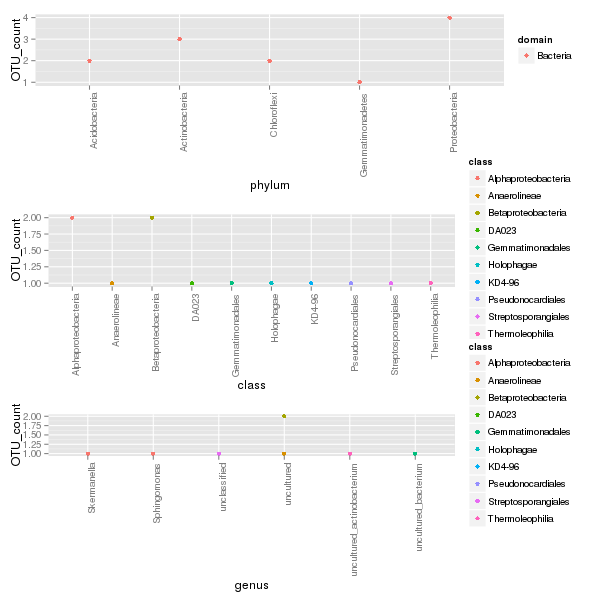

In [29]:
%%R -h 600 -w 600

tbl.j = tbl.j %>%
    arrange(Negative_Control)

tbl.j.phylum = tbl.j %>%
    group_by(domain, phylum) %>%
    summarize(
        OTU_count = n(),
        abundance = sum(Negative_Control)
    )

p1 = ggplot(tbl.j.phylum, aes(phylum, OTU_count, color=domain)) +
    geom_point() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1)
        )


tbl.j.class = tbl.j %>%
    group_by(class) %>%
    summarize(
        OTU_count = n(),
        abundance = sum(Negative_Control)
    )

p2 = ggplot(tbl.j.class, aes(class, OTU_count, color=class)) +
    geom_point() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1)
        )


tbl.j.genus = tbl.j %>%
    group_by(class, genus) %>%
    summarize(
        OTU_count = n(),
        abundance = sum(Negative_Control)
    )

p3 = ggplot(tbl.j.genus, aes(genus, OTU_count, color=class)) +
    geom_point() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1)
        )

grid.arrange(p1, p2, p3, ncol=1)